In [3]:
import torch 

from torch.utils.data import DataLoader 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
import torchvision.transforms as transforms 
import torchvision.datasets as dsets 

import matplotlib.pyplot as plt 
import numpy as np 

%matplotlib inline 

In [2]:
train_dataset = dsets.FashionMNIST(root='./data', 
                                   train=True, 
                                   transform=transforms.ToTensor(), 
                                   download=True)

test_dataset = dsets.FashionMNIST(root='./data', 
                                  train=False, 
                                  transform=transforms.ToTensor(), 
                                  download=True)

100%|██████████| 26421880/26421880 [00:19<00:00, 1361562.46it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 111208.22it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:04<00:00, 963068.11it/s] 


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 7684084.34it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [54]:
batch_size =100 
n_iters = 5000 
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Label 9


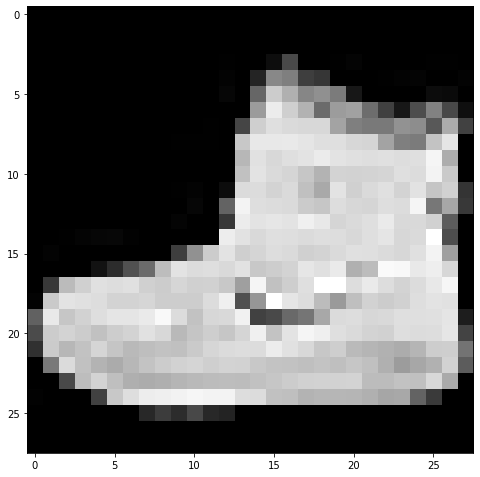

In [55]:
'''
0: T-shirt/top
1: Trouser 
2: Pullover
3: Dress 
4: Coat 
5: Sandal 
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot
'''

show_img, labels = next(iter(train_dataset))

show_img = show_img.numpy().reshape(28, 28)
print(f'Label {labels}')

plt.figure(figsize=(8, 9))
plt.imshow(show_img, cmap='gray');


Text(0.5, 1.0, 'Sigmoid Function')

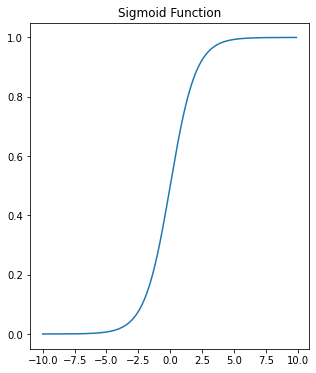

In [56]:
x = torch.arange(-10., 10., 0.1)
plt.figure(figsize=(5, 6))
plt.plot(x.numpy(), torch.sigmoid(x).numpy())
plt.title('Sigmoid Function')

Text(0.5, 1.0, 'Sigmoid Function.')

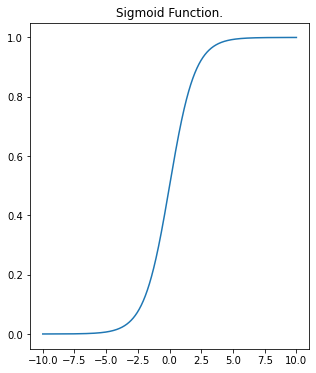

In [57]:
x = torch.linspace(-10, 10, 1000)
f = lambda x: 1 / (1 + torch.exp(-x))

plt.figure(figsize = (5, 6))
plt.plot(x.numpy(), f(x).numpy())
plt.title('Sigmoid Function.')

In [58]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AutoEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, images):
        outputs = self.fc1(images)
        outputs = self.leaky_relu(outputs)
        outputs = self.fc2(outputs)
        outputs = self.sigmoid(outputs)
        
        return outputs

In [59]:
input_dim = 28 * 28
hidden_dim = int(input_dim*1.5)
output_dim = input_dim

model = AutoEncoder(input_dim, hidden_dim, output_dim)

In [60]:
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [61]:
num_params_group = len(list(model.parameters()))
for group_idx in range(num_params_group):
    print(list(model.parameters())[group_idx].size())

torch.Size([1176, 784])
torch.Size([1176])
torch.Size([784, 1176])
torch.Size([784])


In [73]:
idx = 0 

dropout = nn.Dropout(0.5)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28)
        model.train()
        optimizer.zero_grad()
        
        # Noisy images
        noisy_images = dropout(torch.ones(images.shape)) * images
        pred_y = model(noisy_images)
        loss = criterion(pred_y, images) # images 간의 차이를 본다. 
        loss.backward()
        optimizer.step()
        
        idx += 1 
        
        if idx % 500 == 0:
            total_test_loss = 0 
            total_samples = 0 
            
            model.eval()
            for images, labels in test_loader:
                noisy_images = dropout(torch.ones(images.shape)) * images 
                outputs = model(noisy_images.view(-1, 28 * 28))
                
                test_loss = criterion(outputs, images.view(-1, 28*28))
                
                total_samples += labels.size(0)
                total_test_loss += test_loss 
                
            mean_test_loss = total_test_loss / total_samples 
            
            print(f'Iteration: {idx}, Average Test Loss: {mean_test_loss.item():.5f}')

Iteration: 500, Average Test Loss: 0.00014
Iteration: 1000, Average Test Loss: 0.00013
Iteration: 1500, Average Test Loss: 0.00013
Iteration: 2000, Average Test Loss: 0.00012
Iteration: 2500, Average Test Loss: 0.00012
Iteration: 3000, Average Test Loss: 0.00012
Iteration: 3500, Average Test Loss: 0.00011
Iteration: 4000, Average Test Loss: 0.00011
Iteration: 4500, Average Test Loss: 0.00011


Label 4


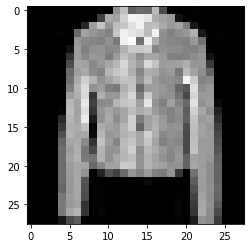

In [74]:
sample_num = 10
raw_img = test_dataset[sample_num][0]
show_img = raw_img.numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');

Label 4


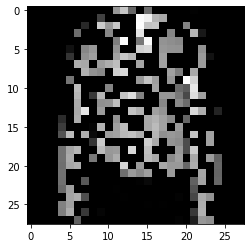

In [75]:
# Test sample: Noisy
sample_num = 10
raw_img = test_dataset[sample_num][0]
noisy_image = dropout(torch.ones(raw_img.shape)) * raw_img
show_img = noisy_image.numpy().reshape(28, 28)
label = test_dataset[sample_num][1]
print(f'Label {label}')
plt.imshow(show_img, cmap='gray');